## Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability from 170Ma-present. The notebook `02-create_probability_maps.ipynb` must have been run previously.

In [1]:
use_extracted_data = False

In [2]:
import glob
import os
import tempfile

import cartopy.crs as ccrs
import pandas as pd
import pygplates
from gplately import (
    PlateReconstruction,
    PlotTopologies,
)
from joblib import Parallel, delayed
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)
from lib.misc import (
    filter_topological_features,
    reconstruct_by_topologies,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

NOTEBOOK = "get_ipython" in dir()

env: PYTHONWARNINGS=ignore::UserWarning


In [3]:
n_jobs = int(os.environ.get("N_JOBS", 8))
verbose = bool(int(os.environ.get("VERBOSE", "1")))
lon_0 = 0.0
projection = ccrs.Mollweide(lon_0)

output_dir = os.path.join("outputs", "global")

imshow_kwargs = dict(
    vmin=0,
    vmax=60,
    cmap="viridis"
)

times = range(171)

### Load plate model files

In [4]:
model_dir = "plate_model"
check_plate_model(model_dir, verbose=True)
feature_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.gpml",
    )
)
rotation_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.rot",
    )
)
coastlines_filename = os.path.join(
    model_dir,
    "StaticGeometries",
    "AgeGridInput",
    "CombinedTerranes.gpml",
)

reconstruction = PlateReconstruction(
    rotation_model=rotation_filenames,
    topology_features=filter_topological_features(feature_filenames),
)
gplot = PlotTopologies(
    plate_reconstruction=reconstruction,
    coastlines=coastlines_filename,
)

### Load training data

In [5]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
training_filename = os.path.join(data_dir, "training_data_global.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]

### Reconstruct deposit data for plots

In [6]:
positives = reconstruct_by_topologies(
    data=(positives[["lon", "lat", "age (Ma)", "label"]]).copy(),
    plate_reconstruction=reconstruction,
    times=times,
)

### Example plot

PU example plot:


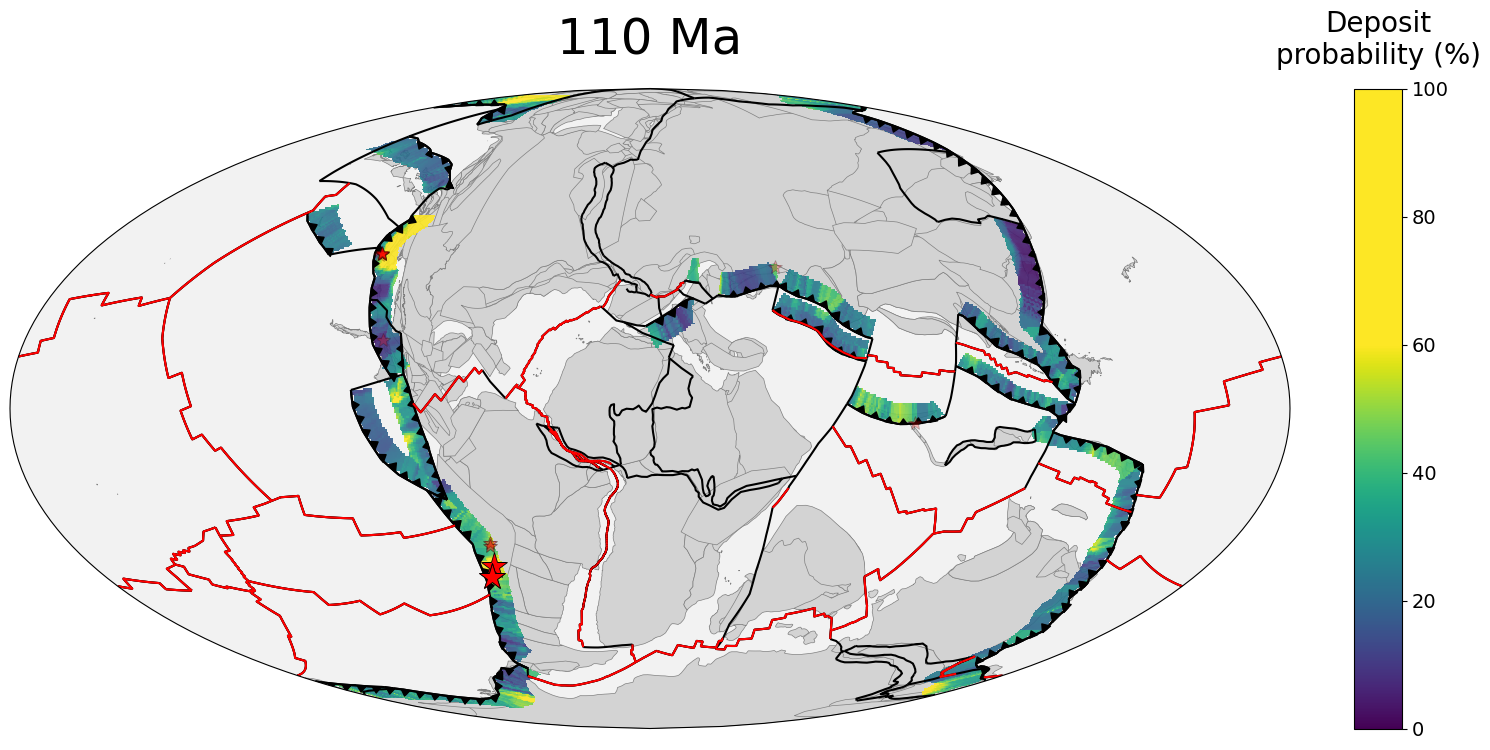

In [7]:
# Example plot (only in notebook)
if NOTEBOOK:
    t_example = 110  # Ma
    gplot.time = t_example
    algorithm = "PU"
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    print(f"{algorithm} example plot:")
    fig = plot(
        gplot=gplot,
        probabilities=os.path.join(
            probs_dir,
            f"probability_grid_{t_example:0.0f}Ma.nc",
        ),
        positives=positives,
        projection=projection,
        time=t_example,
        central_meridian=lon_0,
        imshow_kwargs=imshow_kwargs,
    )

### Create all plots

In [8]:
for algorithm in ("PU", "SVM"):
    output_filename = os.path.join(
        output_dir,
        algorithm,
        "probability_animation.mp4",
    )
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    # Create all plots
    with tempfile.TemporaryDirectory() as tmpdir, \
            Parallel(n_jobs=n_jobs, verbose=int(verbose)) as parallel:
        topologies_tmp = os.path.join(tmpdir, "topologies.gpml")
        filter_topological_features(feature_filenames).write(topologies_tmp)
        gplot_kw = dict(
            rotation_model=rotation_filenames,
            topology_features=topologies_tmp,
            coastlines=coastlines_filename,
        )

        output_filenames = [
            os.path.join(tmpdir, f"image_{t:0.0f}Ma.png")
            for t in times
        ]
        parallel(
            delayed(plot)(
                gplot=gplot_kw,
                probabilities=os.path.join(
                    probs_dir,
                    f"probability_grid_{t:0.0f}Ma.nc",
                ),
                projection=projection,
                time=t,
                positives=positives,
                output_filename=o,
                central_meridian=lon_0,
                imshow_kwargs=imshow_kwargs,
            )
            for t, o in zip(times, output_filenames)
        )

        with ImageSequenceClip(output_filenames[::-1], fps=5) as clip:
            clip.write_videofile(
                output_filename,
                fps=30,
                codec="mpeg4",
                bitrate="5000k",
                audio=False,
                threads=n_jobs,
                logger=None,
                ffmpeg_params=[
                    "-vf",
                    "pad=ceil(iw/2)*2:ceil(ih/2)*2",
                ],
            )

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.1min


[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:  9.1min finished


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.9min


[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:  8.5min finished
